# Assignment 3

## Objectives
1. To build an Artificial Neural Network (ANN) for flood-detection (categorical) with the provided data.
2. To optimize the network to maximize prediction accuracy while preventing overfitting through hyperparameter tuning.
3. To conclude with the best ANN-configuration for the data with the highest accuracy.
4. To compare with the class-exercise setup of the ANN

## Methodology
The following processes are followed to meet the objectives:
1. The dataset is scanned for empty/null or "NA" values that can affect the training.
2. A model skeleton is developed with **N** neurons fed by the relevant input arrays, followed by varying number of layers and neurons/nodes per layer
3. The model is then compiled with varying loss-functions and optimizers options
4. Different configurations are checked for while seeking minimal losses
5. The final *best* configuration is displayed

**Possible Parameters to Tune:**
* Number of hidden layers
* Number of neurons per layer
* Activation functions
* Optimizer functions
* Batch sizes
* Epoch numbers

## Implementation

### Initialization

First, the libraries are imported:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import random
import statistics

Since the numpy-array can only hold a single data-type, a numerical dataset loading without error directly indicates an absence of nulls (expected to be strings). Therefore, loading the data from the text file with the appropriate delimiter specified:

In [2]:
data = np.loadtxt('flood_var.csv', delimiter=",")

# It is assumed that the only relevant inputy arrays are till array index 5 from the classroom
x = data[:,:6]
y = data[:,-1]

# Random state seeded for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

### Multiple-trial Evaluations

Initially, multiple trials of **Classroom Workout** model are evaluated to check if the error-epoch runs are deterministic/reproducible. The model is created within a loop to avoid carryover of any previous development information to the next iteration.

First, a list of **Metrics for model performance** were selected and built into a list.

In [3]:
eval_met = ["Binary Crossentropy Loss","Binary Accuracy (0.5 Threshold)", "Recall (0.5 Threshold)"]

**Trial Iterations:**

The training data has further been split-up into validation sets that are used to assess the training segment. The evaluation is done solely on the test data. To ensure a degree of reproducibility, the random number generator is seeded to 42. Then 5 iterations (limited to this number considering computational limitations to the tuning exercise later) of the same model-building to evaluating is repeated to observe how the errors and performance metrics change.

For every run, **kernel_initializer** is set to *'normal'* and **bias_initializer** is set to *'zeros'* during the sequential model creation for limited divergence of the training outputs.

Trial 1:


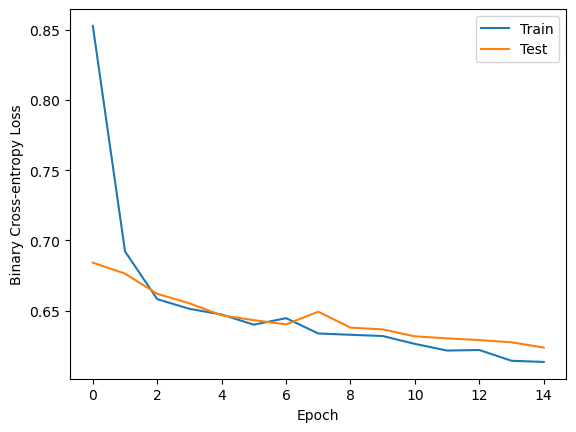

Binary Crossentropy Loss: 0.62
Binary Accuracy (0.5 Threshold): 0.67
Recall (0.5 Threshold): 0.26
Trial 2:


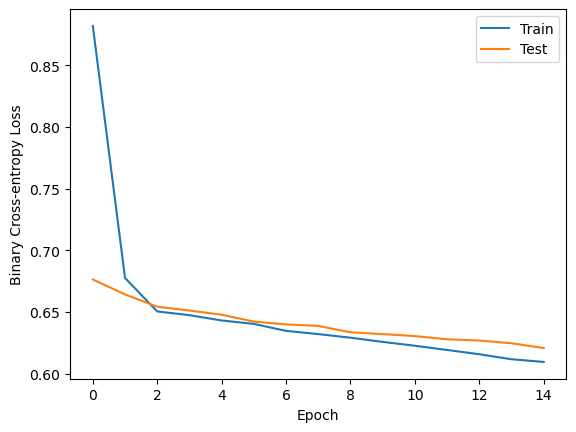

Binary Crossentropy Loss: 0.62
Binary Accuracy (0.5 Threshold): 0.67
Recall (0.5 Threshold): 0.36
Trial 3:


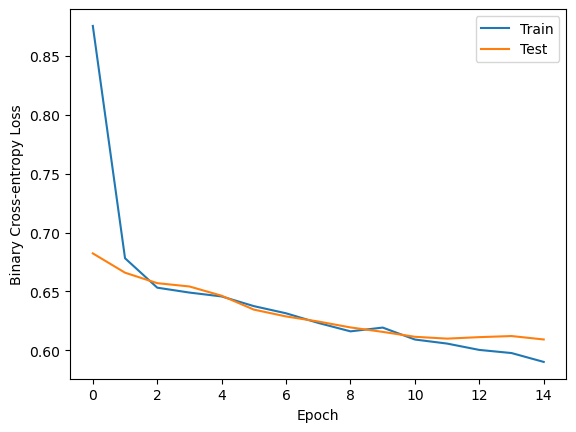

Binary Crossentropy Loss: 0.61
Binary Accuracy (0.5 Threshold): 0.69
Recall (0.5 Threshold): 0.4
Trial 4:


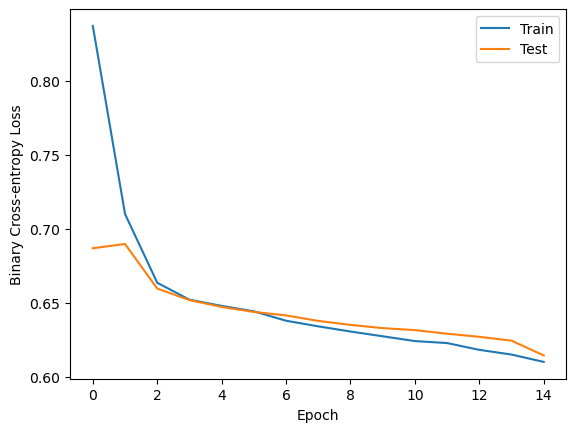

Binary Crossentropy Loss: 0.62
Binary Accuracy (0.5 Threshold): 0.66
Recall (0.5 Threshold): 0.25
Trial 5:


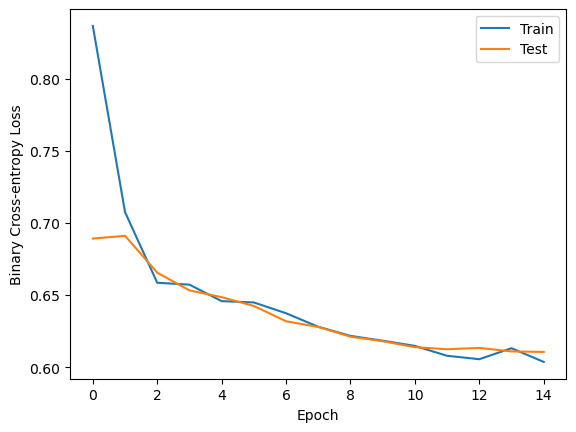

Binary Crossentropy Loss: 0.61
Binary Accuracy (0.5 Threshold): 0.68
Recall (0.5 Threshold): 0.41


In [4]:
#Iteration Block
# Model Recall List - Explained in block below
mod_rec = []

for trial in range(5):
    # Seed random value to 42
    random.seed(42)
    
    # Print trial block
    print(f"Trial {trial+1}:")
    
    # Create Model Skeleton
    model = keras.Sequential([
        layers.Input((6,)),
        layers.Dense(10, activation="relu", kernel_initializer="normal", bias_initializer="zeros"),
        layers.Dense(6, activation="relu", kernel_initializer="normal", bias_initializer="zeros"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    # Compile and Fit Model 
    # Thresholds for Binary Accuracy and Recall are set to 0.5 to automatically map the sigmoid outputs to binary
    model.compile("Adam", "binary_crossentropy",metrics=[keras.metrics.BinaryAccuracy(threshold=0.5), keras.metrics.Recall(thresholds=0.5)])
    
    # Only the training segment is fed for fitting, while a further part of it is kept for validation
    history = model.fit(x_train,y_train, epochs=15, validation_split=0.3, verbose=0)

    # Plot the "Train" and "Test" set losses against epochs    
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-entropy Loss")
    plt.legend(["Train","Test"])
    plt.show()

    # Write evaluation results to a variable
    results = model.evaluate(x_test,y_test, verbose=0)

    # Print the values of selected evaluation metrics for the entire dataset (train and test)
    for para, val in zip(eval_met,results):
        print(f"{para}: {round(val,2)}")

    # Append model-recalls into list
    mod_rec.append(results[2])

The losses are **not the same** for the different trials of the same model. This points to a difference in starting values that are randomly selected. For instance, the weights of the neural network for the very first iteration in the epoch. Also, the training data is shuffled for batches so the losses vary with this sequence. Therefore, each run of the same model *will* produce different losses and accordingly, different performance metrics. 

For this model, the focus is on flood prediction and it is much more important that the **False Negatives** are as low as possible while keeping the **True Positives** sufficiently high. Therefore, **Recall** is a good evaluation metric. To tackle the randomness of the model-building, the deciding evaluation of each model is taken as the average of recalls of all three runs, imitating ensemble behavior. 

In [5]:
print("Model Recall: ",round(statistics.mean(mod_rec),2),"\xB1",round(statistics.stdev(mod_rec),2))

Model Recall:  0.34 ± 0.08


The **best way to present the result of the model** is to report the statistical averages of the accuracy and the standard-deviations from several trial samples and choose the best one with the maximum average recall.

### Improvement of the Model (Tuning Hyperparameters)

The model can be improved by searching for the optimal values for each of hyperparameters that were listed in methodology. Certain simplifications have been set owing to computational limitations:
* Activation function of the output is set to **sigmoid** for all cases as this is the preferred activation function for binary classification.
* The activation functions of the hidden layers are homogeneous (same for all layers for one model configuration).
* The validation split is set to a constant of 0.3 for simplicity.
* The kernel and bias initializations are constant across all cases (normal and zeros) and the random generator is set to 42 for comparable/reproducible results
* Only Binary cross-entropy has been used as Hinge Loss functions are more suited for Support Vector Machines
* Only the case of **2** and **3** hidden-layers have been investigated.

The list of all different hyperparameters with their respective values considered are created. Then, permutations of these are created using **itertools**.

In [6]:
n_neus = [8,16]
act_funcs = ["relu","tanh"]
optms = ["Rmsprop","Adam"]
bat_sizes = [32,64]
n_epochs = [25,50]

Then for the consideration of **2** hidden layers, two different number of neurons are required which is obtained as:

In [7]:
import itertools
# n_neus twice for each neuron layer
params = list(itertools.product(n_neus, n_neus, act_funcs, optms, bat_sizes, n_epochs))
print("Number of Combinations: ",len(params))

Number of Combinations:  64


Then, the optimum configuration is searched for over the defined ranges of parameters as:

In [8]:
# Initialize optimums to extract fromt the loop
optimum_config = []
optimum_recall = 0
optimum_recall_sd = 0

for neus1, neus2, act_func, optm, bat_size, n_epoch in params:
    # Model recalls for 5 iterations of the same model configuration
    mod_recall = []
    
    for trial in range(5):
        # Create Model Skeleton
        random.seed(42)
        model = keras.Sequential([
            layers.Input((6,)),
            layers.Dense(neus1, activation=act_func, kernel_initializer="normal", bias_initializer="zeros"),
            layers.Dense(neus2, activation=act_func, kernel_initializer="normal", bias_initializer="zeros"),
            layers.Dense(1, activation="sigmoid", kernel_initializer="normal", bias_initializer="zeros")
        ])
        
        # Compile and Fit Model
        model.compile(optm, "binary_crossentropy",metrics=["binary_accuracy","recall"])
        history = model.fit(x_train,y_train, epochs=n_epoch, batch_size=bat_size, validation_split=0.3, verbose=0)
        results = model.evaluate(x_test, y_test, verbose=0)
        mod_recall.append(results[2])
    
    if statistics.mean(mod_recall) > optimum_recall:
        optimum_recall = statistics.mean(mod_recall)
        optimum_recall_sd = statistics.stdev(mod_recall)
        optimum_config = [neus1, neus2, act_func, optm, bat_size, n_epoch]
        print(optimum_config, " result in improved optimal recall of ", round(optimum_recall,2),"\xB1",round(optimum_recall_sd,2))

print()
print("Overall Optimum Configuration:")
print("Layer 1 Neurons, Layer 2 Neurons, Activation Function, Optimizer, Batch Size, Epochs: ")
print(optimum_config)
print("Result in optimal recall of ", round(optimum_recall,2),"\xB1",round(optimum_recall_sd,2))

[8, 8, 'relu', 'Rmsprop', 32, 25]  result in improved optimal recall of  0.41 ± 0.12
[8, 8, 'relu', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.48 ± 0.08
[8, 8, 'relu', 'Adam', 64, 50]  result in improved optimal recall of  0.49 ± 0.04
[16, 8, 'relu', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.51 ± 0.05

Overall Optimum Configuration:
Layer 1 Neurons, Layer 2 Neurons, Activation Function, Optimizer, Batch Size, Epochs: 
[16, 8, 'relu', 'Rmsprop', 32, 50]
Result in optimal recall of  0.51 ± 0.05


An increase in precision is observed for the optimized configuration compared to the previous **classroom configuration**. Therefore, the optimized model outperforms the default settings.

Now for **3** hidden layers, three different numbers of neurons are required as:

In [9]:
# n_neus thrice for each neuron layer
params = list(itertools.product(n_neus, n_neus, n_neus, act_funcs, optms, bat_sizes, n_epochs))
print("Number of Combinations: ",len(params))

Number of Combinations:  128


In [10]:
# Initialize optimums to extract fromt the loop
optimum_config = []
optimum_recall = 0
optimum_recall_sd = 0

for neus1, neus2, neus3, act_func, optm, bat_size, n_epoch in params:
    # Model recalls for 5 iterations of the same model configuration
    mod_recall = []
    
    for trial in range(5):
        # Create Model Skeleton
        random.seed(42)
        model = keras.Sequential([
            layers.Input((6,)),
            layers.Dense(neus1, activation=act_func, kernel_initializer="normal", bias_initializer="zeros"),
            layers.Dense(neus2, activation=act_func, kernel_initializer="normal", bias_initializer="zeros"),
            layers.Dense(neus3, activation=act_func, kernel_initializer="normal", bias_initializer="zeros"),
            layers.Dense(1, activation="sigmoid", kernel_initializer="normal", bias_initializer="zeros")
        ])
        
        # Compile and Fit Model
        model.compile(optm, "binary_crossentropy",metrics=["binary_accuracy","recall"])
        history = model.fit(x_train,y_train, epochs=n_epoch, batch_size=bat_size, validation_split=0.3, verbose=0)
        results = model.evaluate(x_test, y_test, verbose=0)
        mod_recall.append(results[2])
    
    if statistics.mean(mod_recall) > optimum_recall:
        optimum_recall = statistics.mean(mod_recall)
        optimum_recall_sd = statistics.stdev(mod_recall)
        optimum_config = [neus1, neus2, neus3, act_func, optm, bat_size, n_epoch]
        print(optimum_config, " result in improved optimal recall of ", round(optimum_recall,2),"\xB1",round(optimum_recall_sd,2))

print()
print("Overall Optimum Configuration:")
print("Layer 1 Neurons, Layer 2 Neurons, Activation Function, Optimizer, Batch Size, Epochs: ")
print(optimum_config)
print("Result in optimal recall of ", round(optimum_recall,2),"\xB1",round(optimum_recall_sd,2))

[8, 8, 8, 'relu', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.27 ± 0.12
[8, 8, 8, 'relu', 'Adam', 32, 25]  result in improved optimal recall of  0.27 ± 0.15
[8, 8, 8, 'tanh', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.34 ± 0.02
[8, 8, 16, 'relu', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.48 ± 0.1
[8, 8, 16, 'relu', 'Adam', 32, 50]  result in improved optimal recall of  0.49 ± 0.1
[8, 16, 16, 'relu', 'Rmsprop', 32, 25]  result in improved optimal recall of  0.51 ± 0.08
[8, 16, 16, 'relu', 'Rmsprop', 32, 50]  result in improved optimal recall of  0.53 ± 0.1

Overall Optimum Configuration:
Layer 1 Neurons, Layer 2 Neurons, Activation Function, Optimizer, Batch Size, Epochs: 
[8, 16, 16, 'relu', 'Rmsprop', 32, 50]
Result in optimal recall of  0.53 ± 0.1


Despite an increase in number of hidden layers, the gain is very minimal and it might not be worth the computation resources for it. Therefore, the **2** hidden layers' optimum-configuration is preferred. The reason for increased performance from default is likely due to the increased batch and epoch sizes that have allowed extended improvement to the base model without overfitting the training set.

### Conclusion

Despite these enhancements to the original model, the final recall is much lower than desired. There are high chances of **False Negatives**, which is risky to accept as a feasible flood predictor as the model will have a tendency to miss actual flood events.